In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR


In [3]:
#read the model
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(1, 4), stride=(1, 2))
        self.bn1 = nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.pool1 = nn.MaxPool2d(kernel_size=(1, 4), stride=(1, 4))
        self.dropout1 = nn.Dropout(p=0.25)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(1, 2), stride=(1, 2))
        self.bn2 = nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.pool2 = nn.MaxPool2d(kernel_size=(1, 4), stride=(1, 4))
        self.dropout2 = nn.Dropout(p=0.25)
        self.fc1 = nn.Linear(1056, 128)
        self.dropout3 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 6)


    def forward(self, x):
        x = torch.unsqueeze(x, 1)
        #print('x:', x.shape)
        x = self.conv1(x)
        #print('conv1:', x.shape)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        #print('conv2:', x.shape)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        x = x.view(x.size(0), -1)
        #print('flatten:', x.shape)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

model = EEGNet()

In [10]:
import numpy as np

def sliding_window(signal, window_size, step_size):
    n_channels, n_samples = signal.shape
    n_windows = int((n_samples - window_size) / step_size) + 1
    windows = np.zeros((n_channels, window_size, n_windows))
    for i in range(n_windows):
        windows[:, :,i ] = signal.iloc[:, i*step_size:i*step_size+window_size]
    return windows

signal = pd.read_csv("C:\\Users\\a1882\Desktop\EEG\eegdata\\raw\lefthand_zyy_05_epocflex_2023.03.22t16.50.54+08.00.md.bp.csv", header=None)
signal = pd.DataFrame(signal)
# 定义滑窗大小和滑动步长
window_size = 128
step_size = 100

# 对信号进行滑窗处理
windows = sliding_window(signal, window_size, step_size)

# 输出滑窗后的信号形状
print("滑窗后信号形状：", windows.shape)
#print(windows)

In [12]:
save_path = 'C:\\Users\\a1882\Desktop\EEG\\new_implement\model\cnn_128_100e_97.pt'
model.load_state_dict(torch.load(save_path, map_location=torch.device('cpu')))
model.eval()
for i in range(windows.shape[2]):
    signal = pd.DataFrame(windows[:,:,i])
    input = torch.from_numpy(signal.values)
    input = input.unsqueeze(0)
    output = model(input.float())
    _, pred = torch.max(output, dim=1)  # 找到预测分数最大的类别，得到预测类别
    label_map = {0: 'lefthand', 1:'read' ,  2:'rest', 3: 'walkbase', 4: 'walkl' ,5: 'walkfocus'}
    print(label_map[pred.item()])


rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
lefthand
lefthand
rest
walkl
walkbase
rest
rest
rest
rest
lefthand
lefthand
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
walkbase
read
lefthand
lefthand
lefthand
lefthand
rest
rest
rest
lefthand
lefthand
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
lefthand
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
walkbase
rest
lefthand
rest
lefthand
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
lefthand
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
lefthand
rest
rest
rest
rest
rest
rest
lefthand
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest
rest


<IPython.core.display.Javascript object>


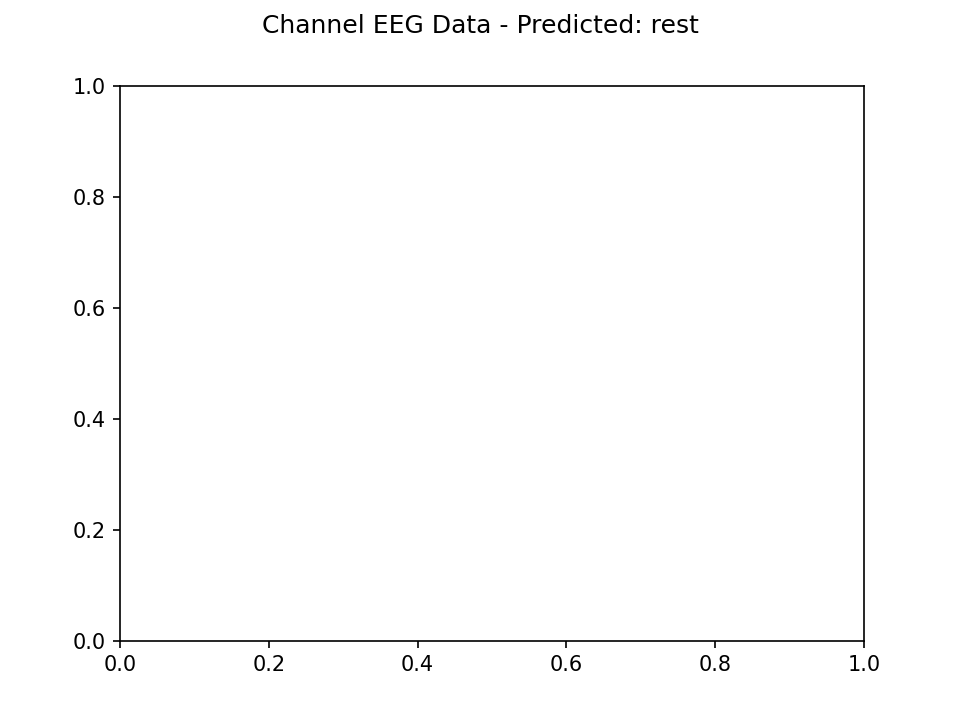

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
save_path = 'C:\\Users\\a1882\Desktop\EEG\\new_implement\model\cnn_128_100e_97.pt'
model.load_state_dict(torch.load(save_path, map_location=torch.device('cpu')))
model.eval()
# Create 32 subplots
fig, axs = plt.subplots()
hex_green = '#00251C'
def update(i):

# for i in range(windows.shape[2]):
    signal_fram = pd.DataFrame(windows[:,:,i])
    input = torch.from_numpy(signal_fram.values)
    input = input.unsqueeze(0)
    output = model(input.float())
    _, pred = torch.max(output, dim=1)  # 找到预测分数最大的类别，得到预测类别
    label_map = {0: 'lefthand', 1:'read' ,  2:'rest', 3: 'walkbase', 4: 'walkl' ,5: 'walkfocus'}
    title = f'Channel EEG Data - Predicted: {label_map[pred.item()]}'
    fig.suptitle(title)

# Create the animation
ani = FuncAnimation(fig, update, frames=windows.shape[2], interval=1000, repeat=False)

# Save the animation as a GIF
ani.save('predict.gif', writer='pillow', fps=1)

# Show the plot (this will also run the animation)
plt.show()
    # print(label_map[pred.item()])

In [26]:
import numpy as np
import pandas as pd
def sliding_window(signal, window_size, step_size):
    n_channels, n_samples = signal.shape
    n_windows = int((n_samples - window_size) / step_size) + 1
    windows = np.zeros((n_channels, window_size, n_windows))
    for i in range(n_windows):
        windows[:, :,i ] = signal.iloc[:, i*step_size:i*step_size+window_size]
    return windows

signal_walkbase = pd.read_csv("C:\\Users\\a1882\Desktop\EEG\eegdata\\raw\\lefthand_zyy_05_epocflex_2023.03.22t16.50.54+08.00.md.bp.csv",header=None)
print("原始信号形状：", signal_walkbase.shape)
signal_walkbase = pd.DataFrame(signal_walkbase)
# 定义滑窗大小和滑动步长
window_size = 128
step_size = 100

# 对信号进行滑窗处理
windows_walkbase = sliding_window(signal_walkbase, window_size, step_size)

# 输出滑窗后的信号形状
print("滑窗后信号形状：", windows_walkbase.shape)

原始信号形状： (33, 15530)
滑窗后信号形状： (33, 128, 155)


<IPython.core.display.Javascript object>


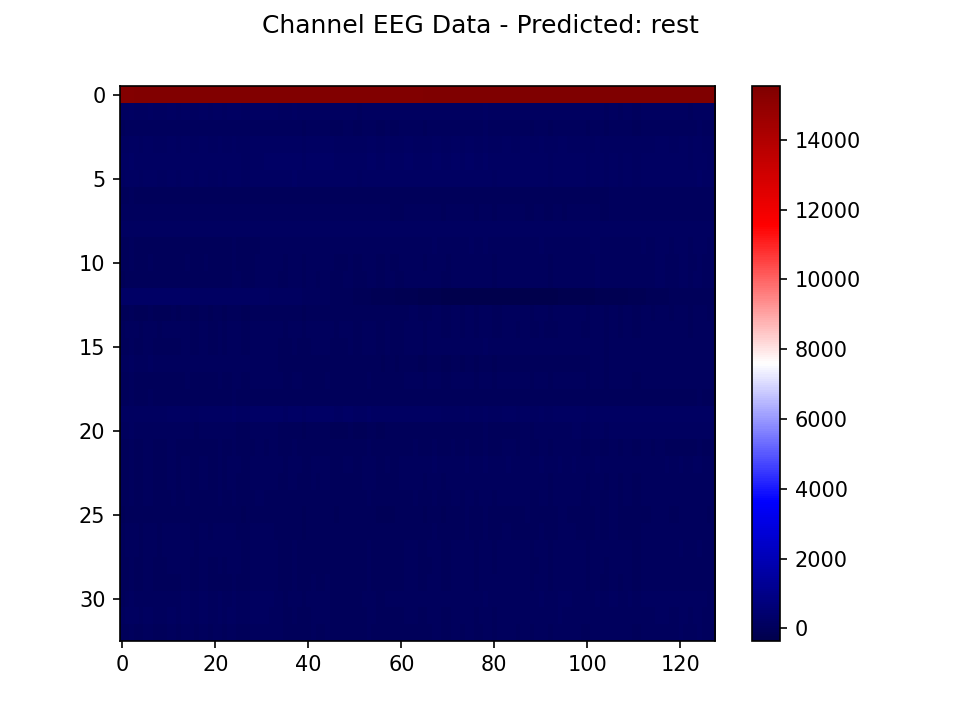

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
%matplotlib notebook
import pandas as pd
from matplotlib.animation import FuncAnimation
save_path = 'C:\\Users\\a1882\Desktop\EEG\\new_implement\model\cnn_128_100e_97.pt'
model.load_state_dict(torch.load(save_path, map_location=torch.device('cpu')))
model.eval()
fig,ax = plt.subplots()

ims = []
for i in range(windows_walkbase.shape[2]):
    im = ax.imshow(windows_walkbase[:,:,i], cmap='seismic', aspect='auto',animated=True)
#     if i == 0:
#         ax.imshow(windows_walkbase[:,:,1], cmap='seismic', aspect='auto')
    ims.append([im])
    input = torch.from_numpy(pd.DataFrame(windows_walkbase[:,:,i]).values)
    input = input.unsqueeze(0)
    output = model(input.float())
    _, pred = torch.max(output, dim=1)  # 找到预测分数最大的类别，得到预测类别
    label_map = {0: 'lefthand', 1:'read' ,  2:'rest', 3: 'walkbase', 4: 'walkl' ,5: 'walkfocus'}
    title = f'Channel EEG Data - Predicted: {label_map[pred.item()]}'
    fig.suptitle(title)
ani = animation.ArtistAnimation(fig, ims, interval=30, blit=True,repeat=False)
fig.colorbar(im, ax=ax)
ani.save('prediction_animation_lh.gif', writer='pillow', fps=1)
plt.show()

C:\Users\a1882\AppData\Local\Temp\ipykernel_23148\1324820480.py:102: UserWarning: You passed in an explicit save_count=500 which is being ignored in favor of frames=117.
  ani = animation.FuncAnimation(fig, animate, frames=117, interval=1000, blit=True, save_count=500)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1024 and 1056x128)

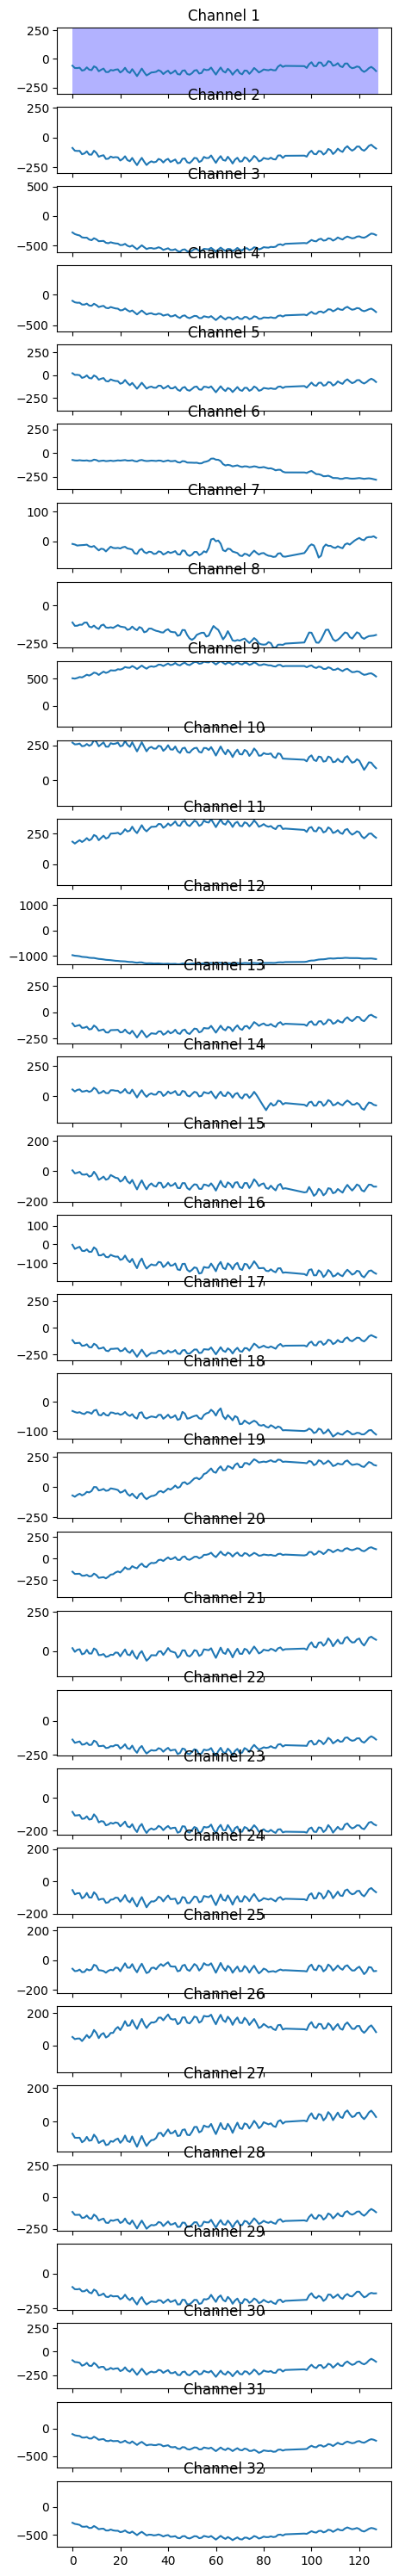

In [24]:
# import numpy as np
# import pandas as pd
# import torch
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# from PIL import Image
# from io import BytesIO

# # 定义标签字典
# label_map = {0: 'lefthand', 1: 'read', 2: 'rest', 3: 'walkbase', 4: 'walkl', 5: 'walkfocus'}

# # 读取数据和模型
# df = pd.read_csv("C:\\Users\\a1882\\Desktop\\EEG\\new_implement\\data\\origin_raw_data\\lefthand_zyy_04_epocflex_2023.03.22t16.48.29+08.00.md.bp.csv", header=None)
# save_path = 'C:\\Users\\a1882\\Desktop\\EEG\\new_implement\\model\\cnn_128_100e_97.pt'
# #read the model
# class EEGNet(nn.Module):
#     def __init__(self):
#         super(EEGNet, self).__init__()
#         self.conv1 = nn.Conv2d(1, 16, kernel_size=(1, 4), stride=(1, 2))
#         self.bn1 = nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#         self.pool1 = nn.MaxPool2d(kernel_size=(1, 4), stride=(1, 4))
#         self.dropout1 = nn.Dropout(p=0.25)
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=(1, 2), stride=(1, 2))
#         self.bn2 = nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#         self.pool2 = nn.MaxPool2d(kernel_size=(1, 4), stride=(1, 4))
#         self.dropout2 = nn.Dropout(p=0.25)
#         self.fc1 = nn.Linear(1056, 128)
#         self.dropout3 = nn.Dropout(p=0.5)
#         self.fc2 = nn.Linear(128, 6)


#     def forward(self, x):
#         x = torch.unsqueeze(x, 1)
#         #print('x:', x.shape)
#         x = self.conv1(x)
#         #print('conv1:', x.shape)
#         x = self.bn1(x)
#         x = torch.relu(x)
#         x = self.pool1(x)
#         x = self.dropout1(x)
#         x = self.conv2(x)
#         #print('conv2:', x.shape)
#         x = self.bn2(x)
#         x = torch.relu(x)
#         x = self.pool2(x)
#         x = self.dropout2(x)
#         x = x.view(x.size(0), -1)
#         #print('flatten:', x.shape)
#         x = self.fc1(x)
#         x = torch.relu(x)
#         x = self.dropout3(x)
#         x = self.fc2(x)
#         return x
# model = EEGNet()
# model.load_state_dict(torch.load(save_path, map_location=torch.device('cpu')))
# model.eval()

# # 创建32个子图
# fig, axs = plt.subplots(nrows=32, figsize=(5, 38), sharex=True)
# lines = []
# for i, ax in enumerate(axs):
#     line, = ax.plot(df.iloc[0, :128], df.iloc[i+1, :128])
#     lines.append(line)
#     ax.set_ylim(df.iloc[i+1, :].min(), df.iloc[i+1, :].max())
#     ax.set_title(f'Channel {i+1}')

# # 创建大的滑动半透明窗
# rect = plt.Rectangle((0, df.min().min()), 128, df.max().max()-df.min().min(), facecolor='blue', alpha=0.3)
# axs[0].add_patch(rect)


# def animate(i):
#     # 更新滑动窗位置
#     rect.set_x(i*100)
#     # 预测当前窗口的标签
#     signal = pd.DataFrame(df.iloc[1:, i*100:i*100+128])
#     input = torch.from_numpy(signal.values)
#     input = input.unsqueeze(0)
#     output = model(input.float())
#     _, pred = torch.max(output, dim=1)
#     title = f'Channel EEG Data - Predicted: {label_map[pred.item()]}'
#     fig.suptitle(title)

#     # 更新子图数据
#     for j, line in enumerate(lines):
#         line.set_xdata(df.iloc[0, i*100:i*100+128])
#         line.set_ydata(df.iloc[j+1, i*100:i*100+128])
#         axs[j].set_xlim(df.iloc[0, i*100:i*100+128].min(), df.iloc[0, i*100:i*100+128].max())
#         axs[j].set_ylim(df.iloc[j+1, i*100:i*100+128].min(), df.iloc[j+1, i*100:i*100+128].max())

#     # 将子图转换为图像并保存
#     fig.canvas.draw()
#     buf = fig.canvas.tostring_rgb()
#     img = Image.frombytes('RGB', fig.canvas.get_width_height(), buf)
#     gif_images.append(img)

#     return lines


# # 创建动画对象并保存为GIF文件
# gif_images = []
# ani = animation.FuncAnimation(fig, animate, frames=117, interval=1000, blit=True, save_count=500)
# ani.save('eeg_prediction.gif', writer='pillOW', fps=1)


